# On the parameters 
- Basic Supporting Functions  
- On the Parameter $\sigma$   
- On the Iteration Number $K$  
- On the Number of Events $n$
- On the Parameter $\sigma$ with One-Dimensional Data (Optional)

## 0. Basic Supporting Functions  

In [1]:
import cv2
import numpy as np
import torch

from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.font_manager import FontProperties

import seaborn as sns

# plt.rcParams['font.sans-serif'] = ['STSong'] # Or the actual font name
# plt.rcParams['axes.unicode_minus'] = False # For Chinese fonts, handle minus sign


stsong_font = FontProperties(fname=None, family='STSong')

cmap = mpl.colormaps['tab10']
colors = cmap(np.linspace(0, 1, 10))
# markers = ["s", "^", ">", "o", "*"]
markers = ["s", "^", ">", "o", "*", "v", "<", "P", "X", "D"]*10


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Figure saved to output/Fig4_case1.pdf


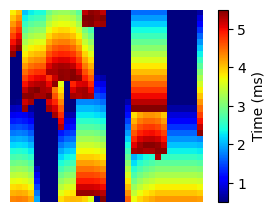

tensor([4.2000, 0.0000], device='cuda:0') 1803
Figure saved to output/Fig4_case2.pdf


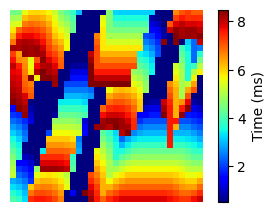

tensor([ 2.2500, -0.7500], device='cuda:0') 1798
Figure saved to output/Fig4_case3.pdf


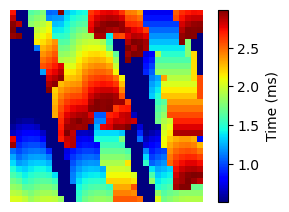

tensor([9.3200, 2.5000], device='cuda:0') 2053


In [2]:
def plot_event_time2d(events, output_file=None, vmin=None, vmax=None):
    """
        events: numpy.ndarray, 形状 (N,4)，列为 x, y, t, p
        vmin, vmax: 时间映射的颜色范围（可选）
    """
    # 分割事件数组
    if isinstance(events,torch.Tensor):
        events = events.cpu().detach().numpy()
    
    x, y, t, p = np.split(events, 4, axis=1)
    x = x.flatten().astype(int)
    y = y.flatten().astype(int)
    t = t.flatten()
    
    # 计算坐标偏移与图像大小
    x0, y0 = np.min(x), np.min(y)
    x_sz = np.max(x) - x0 + 1
    y_sz = np.max(y) - y0 + 1
    
    # 创建空图像，行对应y，列对应x
    img = np.zeros((x_sz, y_sz))+0.0
    
    # 赋值：注意索引顺序是 img[y, x]
    for xi, yi, ti in zip(x, y, t):
        yi_idx = yi - y0
        xi_idx = xi - x0
        img[xi_idx, yi_idx] = max(img[xi_idx, yi_idx], ti)  # 同点多事件取最大时间
    
    # 设置vmin/vmax默认值
    if vmin is None:
        vmin = np.min(t)
    if vmax is None:
        vmax = np.max(t)

    plt.figure(figsize=(4, 2.5))
    plt.imshow(img, cmap='jet', vmin=vmin, vmax=vmax)
    plt.colorbar(label='Time (ms)')
    plt.axis('off')
    # plt.title('2D Event Time Visualization')
    
    if output_file is not None:
        plt.savefig(output_file, bbox_inches='tight', pad_inches=0.1)
        print(f"Figure saved to {output_file}")
    plt.show()

for i in range(1,4):
    data = np.load(f'./data/test_block{i}.npz')
    evts = data['event_block']
    # evts = torch.Tensor(temp[np.argsort(temp[:, 2])]).to(device)
    plot_event_time2d(evts, output_file=f"output/Fig4_case{i}.pdf")
    true_v = torch.Tensor(data['true_velocity'].flatten()).to(device)
    print(true_v,len(evts))

## 1. On the Parameter $\sigma$ Settings

Starting brute-force grid search for displacement estimation.
This may take several minutes (~10 min) due to the exhaustive nature of the search...


Running case 3: 100%|█████████████████████████| 101/101 [03:02<00:00,  1.81s/it]
/tmp/ipykernel_5857/3170705989.py:61: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


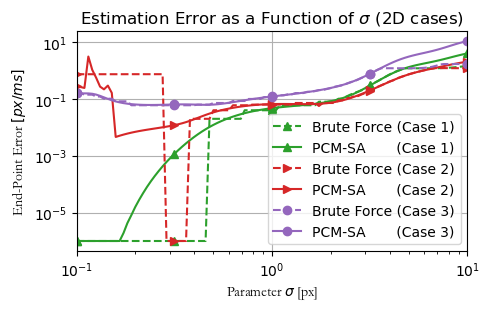

In [3]:
from kernels.pcm import objective2d_origin,estimatePCM

def Exp2D():
    print("Starting brute-force grid search for displacement estimation.")
    print("This may take several minutes (~10 min) due to the exhaustive nature of the search...")
    plt.figure(figsize=(5,3))
    
    for i in range(1,4):
        data = np.load(f'./data/test_block{i}.npz')
        temp = data['event_block']
        evts = torch.Tensor(temp[np.argsort(temp[:, 2])]).to(device)
        evts = evts[:1000]
        true_v = torch.Tensor(data['true_velocity'].flatten()).to(device)
        
        v_vals = torch.linspace(-1.2, 1.2, steps=121, device=device) # The 
        # v_vals = torch.linspace(-1.2, 1.2, steps=5, device=device)
        vy, vx = torch.meshgrid(v_vals, v_vals, indexing="ij")  
        v = torch.stack([vx.reshape(-1)+true_v[0], vy.reshape(-1)+true_v[1]], dim=1)  # shape: (21*21, 2)
        
        sigmas = np.power(10, np.linspace(-1,1,101))
        errors_bf = np.zeros_like(sigmas, dtype=np.float32)
        errors_pcm = np.zeros_like(sigmas, dtype=np.float32)
        
        for k, sigma in enumerate(tqdm(sigmas, desc=f"Running case {i}")):
            step = 200
            loss = torch.zeros(len(v), device=device)
            for j in range(0,len(v),step):    
                l,J,H = objective2d_origin(evts, v[j:j+step], sigma2=sigma**2, tau2=0.0, compute_grad=False, compute_hessian=False)
                loss[j:j+step] = l
            
            indx = torch.argmax(loss)
            error_bf = true_v-v[indx]
            errors_bf[k]= torch.norm(error_bf).cpu().detach().numpy()
    
            vn, loss = estimatePCM(evts, sigma2_min=sigma**2, iter_n=12)
            error_pcm = true_v-vn.flatten()
            errors_pcm[k]= torch.norm(error_pcm).cpu().detach().numpy()

        errors_bf = np.clip(errors_bf, a_min=1e-6, a_max=None)
        errors_pcm = np.clip(errors_pcm, a_min=1e-6, a_max=None)
        plt.plot(sigmas, errors_bf, "--", color=colors[i+1], marker=markers[i], markevery=25,
                 label=f"{'Brute Force'.ljust(12)}(Case {i})")
        plt.plot(sigmas, errors_pcm, color=colors[i+1], marker=markers[i], markevery=25, 
                 label=f"{'PCM-SA'.ljust(13)}(Case {i})")

    plt.legend(loc=4)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([1e-1, 1e1])
    plt.grid(True)
    
    # ===== 1. 中文标签并保存 =====
    plt.xlabel('参数 $\\sigma$ [px]', fontproperties=stsong_font)
    plt.ylabel('端点误差 $[px/ms]$', fontproperties=stsong_font)
    plt.tight_layout()
    plt.savefig("output/Fig5_1_sigma_2d_zh.pdf")
    
    # ===== 2. 英文标签并保存 =====
    plt.xlabel('Parameter $\\sigma$ [px]')
    plt.ylabel('End-Point Error $[px/ms]$')
    plt.tight_layout()
    plt.savefig("output/Fig5_1_sigma_2d.pdf")
    
    # ===== 3. 显示图像 =====
    plt.title("Estimation Error as a Function of $\\sigma$ (2D cases)")
    plt.show()

Exp2D()

## 2. On the Iteration Number $K$  

Running case 3: 100%|██████████████████████████| 20/20 [00:00<00:00, 217.36it/s]
/tmp/ipykernel_5857/3905753998.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


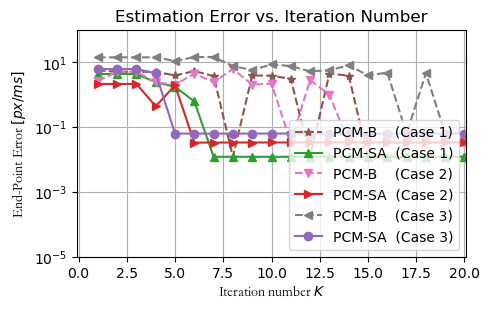

In [4]:
def ExpIter():
    plt.figure(figsize=(5, 3))
    
    for i in range(1, 4):
        data = np.load(f'./data/test_block{i}.npz')
        temp = data['event_block']
        evts = torch.Tensor(temp[np.argsort(temp[:, 2])]).to(device)
        true_v = torch.Tensor(data['true_velocity'].flatten()).to(device)
        
        sigma = 0.5
        n_events = 1000  # 固定事件数量
        evts_t = evts[:n_events]
        iters = np.arange(1, 21, 1)  # 迭代次数 1 到 64
        
        errors_iter_sa = np.zeros_like(iters, dtype=np.float32)
        for k, iter_n in enumerate(tqdm(iters, desc=f"Running case {i}")):
            vn, loss = estimatePCM(evts_t, sigma2_min=sigma**2, iter_n=int(iter_n))
            error = true_v - vn.flatten()
            errors_iter_sa[k] = torch.norm(error).cpu().detach().numpy()
        errors_iter_sa = np.clip(errors_iter_sa, a_min=1e-6, a_max=None)

        errors_iter_b = np.zeros_like(iters, dtype=np.float32)
        for k, iter_n in enumerate(tqdm(iters, desc=f"Running case {i}")):
            vn, loss = estimatePCM(evts_t, objective2d=objective2d_origin, sigma2_min=sigma**2, iter_n=int(iter_n))
            error = true_v - vn.flatten()
            errors_iter_b[k] = torch.norm(error).cpu().detach().numpy()
        errors_iter_b = np.clip(errors_iter_b, a_min=1e-6, a_max=None)
        plt.plot(iters, errors_iter_b, "--", color=colors[i+4], marker=markers[i+3], label=f"{'PCM-B'.ljust(8)} (Case {i})")
        plt.plot(iters, errors_iter_sa, "-", color=colors[i+1], marker=markers[i], label=f"{'PCM-SA'.ljust(8)}(Case {i})")


    plt.legend(loc=4)
    plt.yscale('log')
    plt.xlim([-0.1, np.max(iters)+0.1])
    plt.ylim([1e-5, 1e2])
    plt.grid(True)
    
    # ===== 1. 中文标签并保存 =====
    plt.xlabel('迭代次数 $K$', fontproperties=stsong_font)
    plt.ylabel('端点误差 $[px/ms]$', fontproperties=stsong_font)
    plt.tight_layout()
    plt.savefig("output/Fig6_2_iter_n_zh.pdf")
    
    # ===== 2. 英文标签并保存 =====
    plt.xlabel('Iteration number $K$')
    plt.ylabel('End-Point Error $[px/ms]$')
    plt.tight_layout()
    plt.savefig("output/Fig6_2_iter_n.pdf")
    
    # ===== 3. 显示图像 =====
    plt.title("Estimation Error vs. Iteration Number")
    plt.show()


ExpIter()

## 3. On Event Count $n$

Running case 1 ([4.2 0. ]): 100%|████████████| 200/200 [00:01<00:00, 110.59it/s]


Case 1: error decreases with event count roughly as O(1/n^2.37) (slope = -2.369)


Running case 2 ([ 2.25 -0.75]): 100%|████████| 200/200 [00:01<00:00, 113.46it/s]


Case 2: error decreases with event count roughly as O(1/n^2.70) (slope = -2.703)


Running case 3 ([9.32 2.5 ]): 100%|██████████| 200/200 [00:01<00:00, 111.06it/s]
/tmp/ipykernel_5857/1774328850.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Case 3: error decreases with event count roughly as O(1/n^2.74) (slope = -2.739)


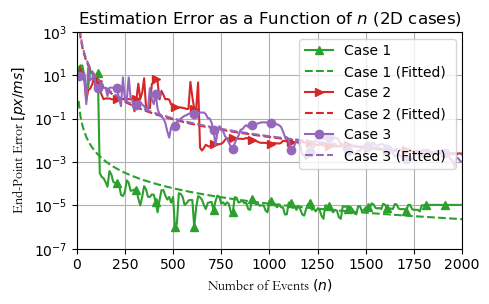

In [5]:
def ExpN():
    plt.figure(figsize=(5,3))
    
    for i in range(1,4):
    # for i in range(1,2):
        data = np.load(f'./data/test_block{i}.npz')
        temp = data['event_block']
        evts = torch.Tensor(temp[np.argsort(temp[:, 2])]).to(device)
        true_v = torch.Tensor(data['true_velocity'].flatten()).to(device)
        
        sigma =0.2
        ns = np.arange(10,2000+1,10) # 事件数量
        errors_pcm = np.zeros_like(ns, dtype=np.float32)
        
        for k, n in enumerate(tqdm(ns, desc=f"Running case {i} ({true_v.cpu().detach().numpy()})")):
            evts_t = evts[:n]

            vn, loss = estimatePCM(evts_t, sigma2_min=sigma**2, iter_n=12)
            error_pcm = true_v-vn.flatten()
            errors_pcm[k]= torch.norm(error_pcm).cpu().detach().numpy()
            # print(error_pcm, errors_pcm[k])
    
        a, b = np.polyfit(np.log(ns[4:]), np.log(errors_pcm[4:]), 1)
        # 此处 log-log 拟合结果为：log(error) ≈ a * log(n) + b
        # 可推出：error ≈ exp(b) * n^a，即 e = O(n^a)
        # 由于误差随 n 增大而减小，所以 a 应为负数
        # 打印 a，等价于报告误差下降的速度：误差 ≈ O(1/n^|a|) 
        # print(f"Case {i}, complexity estimate: error = O(1/n^{abs(a):.2f}) (slope a = {a:.3f})")
        print(f"Case {i}: error decreases with event count roughly as O(1/n^{abs(a):.2f}) (slope = {a:.3f})")

        # ===========================================================
        
        errors_fit = np.exp(a*np.log(ns) +b)
        errors_fit = np.clip(errors_fit, a_min=1e-6, a_max=None)
        errors_pcm = np.clip(errors_pcm, a_min=1e-6, a_max=None)

        plt.plot(ns, errors_pcm, color=colors[i+1], marker=markers[i], markevery=10, label=f"Case {i}")
        plt.plot(ns, errors_fit, "--",color=colors[i+1], label=f"Case {i} (Fitted) ")

    
    plt.legend(loc=1)
    # plt.xscale('log')
    plt.yscale('log')
    plt.xlim([-0.1, np.max(ns) + 1.1])
    plt.ylim([1e-7, 1e3])
    plt.grid(True)
    
    # ===== 1. 中文标签并保存 =====
    plt.xlabel('事件数量 $n$', fontproperties=stsong_font)
    plt.ylabel('端点误差 $[px/ms]$', fontproperties=stsong_font)
    plt.tight_layout()
    plt.savefig("output/Fig7_3_number_2d_zh.pdf")
    
    # ===== 2. 英文标签并保存 =====
    plt.xlabel('Number of Events $(n)$')
    plt.ylabel('End-Point Error $[px/ms]$')
    plt.tight_layout()
    plt.savefig("output/Fig7_3_number_2d.pdf")
    
    # ===== 3. 显示图像（英文标题） =====
    plt.title("Estimation Error as a Function of $n$ (2D cases)")
    plt.show()

ExpN()

## 4. On the Parameter $\sigma$ with One-Dimensional Data (Optional)

In [6]:
def objective1d_origin(x, t, v, sigma2=1.0, tau2=0.0, compute_grad=True, compute_hessian=True):
    """
    Original objective function without temporal smoothing.
    Args:
        v (Tensor): velocities to evaluate, shape (B,)
        x (Tensor): event x-positions, shape (N,)
        t (Tensor): event timestamps, shape (N,)
        sigma2 (float): spatial Gaussian variance_subpixel_correlation
    Returns:
        Tensor: objective values for each v, shape (B,)
    """
    sigma2 = sigma2 + tau2

    v = v[:, None, None]  # shape: (B, 1, 1) for broadcasting
    xij = x[None, None, :] - x[None, :, None]  # x_i - x_j, shape: (1, N, N)
    tij = t[None, None, :] - t[None, :, None]  # t_i - t_j, shape: (1, N, N)
    tij2 = tij * tij               # (1, N, N)

    bx = xij - v * tij  # back-projected spatial offset
    bx2 = bx * bx       # squared offset

    coeff = 1.0 / torch.sqrt(torch.tensor(2 * torch.pi * sigma2, device=x.device))
    exponent = torch.exp(-0.5 * bx2 / sigma2)  # Gaussian kernel

    loss = coeff * torch.mean(exponent, dim=(1, 2))  # average over all i, j pairs

    J, H = None, None
    if compute_grad:
        J = coeff*torch.mean(bx * tij * exponent, dim=(1, 2))/sigma2
    if compute_hessian:
        H = coeff*torch.mean(exponent * tij2 * (bx2 / sigma2 ** 2 - 1 / sigma2), dim=(1, 2))
    return loss, J, H



def objective1d_smooth(x,t,v,sigma2=1.0, tau2=0.0, compute_grad=True, compute_hessian=True):
    """
    Smoothed objective function with time-dependent Gaussian variance.
    Args:
        x (Tensor): event x-positions, shape (N,)
        t (Tensor): event timestamps, shape (N,)
        v (Tensor): velocities to evaluate, shape (B,)
        sigma2 (float): base spatial variance
        tau2 (float): temporal smoothness coefficient
    Returns:
        Tensor: objective values for each v, shape (B,)
    """
    v = v[:, None, None]  # shape: (B, 1, 1)
    xij = x[None, None, :] - x[None, :, None]  # shape: (1, N, N)
    tij = t[None, None, :] - t[None, :, None]  # shape: (1, N, N)
    tij2 = tij * tij  # square of time difference
    
    bx = xij - v * tij  # back-projected spatial offset， shape: (B, N, N)
    bx2 = bx * bx       # squared offset
    
    denom = sigma2 + tij2 * tau2  # total variance with temporal smoothing
    coeff = 1.0 / torch.sqrt(2 * torch.pi * denom)  # adaptive normalization
    exponent = torch.exp(-0.5 * bx2 / denom)  # Gaussian kernel with variable width
    
    loss = torch.mean(coeff * exponent, dim=(1, 2))  # mean density over all pairs
    
    J, H = None, None
    if compute_grad:
        J = torch.mean(coeff * bx * tij * exponent/denom, dim=(1, 2))
    if compute_hessian:
        H = torch.mean(coeff * exponent * tij2 * (bx2 / denom ** 2 - 1 / denom), dim=(1, 2))
    return loss, J, H

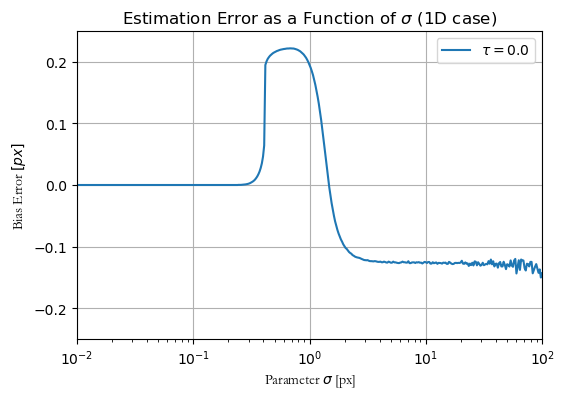

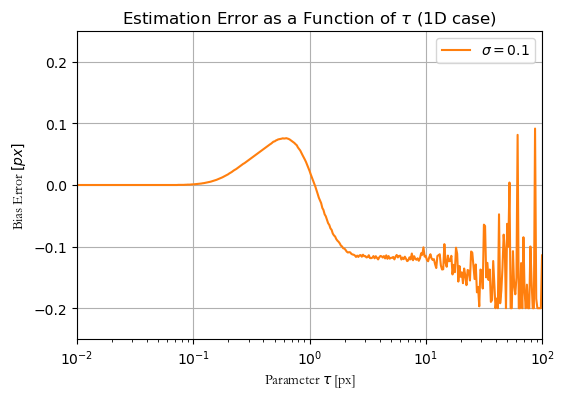

In [7]:
def Exp1D():
    x1 = np.array([3,4,5,5,6,7,8,6,7,8])
    t1 = np.array([1.0,2.0,3.0,2.0,3.0,4.0,5.0,1.0,2.0,3.0])
    x1 = torch.tensor(x1, dtype=torch.float32)  # shape (N,)
    t1 = torch.tensor(t1, dtype=torch.float32)
    
    sigmas = np.power(10,np.linspace(-2,2,401))
    tau2 =  0.0
    
    v_sigma = np.zeros_like(sigmas)
    for k, sigma in enumerate(sigmas):
        sigma2 = sigma**2
        # Create velocity candidates
        v0 = torch.linspace(0.8, 1.5, 3501)
        
        # Evaluate both objective functions
        loss, J, H = objective1d_origin(x1, t1, v0, sigma2=sigma2, tau2=tau2, compute_grad=False, compute_hessian=False)
        v_sigma[k] = v0[torch.argmax(loss)]

    sigma = 0.1
    taus = np.power(10,np.linspace(-2,2,401))

    v_tau = np.zeros_like(taus)
    for k, tau in enumerate(taus):
        sigma2 = sigma**2
        # Create velocity candidates
        v0 = torch.linspace(0.8, 1.5, 3501)
        
        # Evaluate both objective functions
        loss, J, H = objective1d_smooth(x1, t1, v0, sigma2=sigma2, tau2=tau*tau, compute_grad=False, compute_hessian=False)
        v_tau[k] = v0[torch.argmax(loss)]
        

    fig = plt.figure(figsize=(6, 4))
    plt.plot(sigmas, v_sigma - 1.0, color=colors[0], label=f"$\\tau=0.0$")
    plt.xscale('log')
    plt.xlim([1e-2, 1e2])
    plt.ylim([-0.25, 0.25])

    plt.grid(True)
    plt.legend(loc=1)

    # ===== 1. 中文坐标轴并保存 =====
    plt.xlabel('参数 $\\sigma$ [px]', fontproperties=stsong_font)
    plt.ylabel('偏差 [px]', fontproperties=stsong_font)
    fig.savefig("output/Fig1_4_sigma_1d_zh.pdf")
    
    # ===== 2. 英文坐标轴并保存 =====
    plt.xlabel('Parameter $\\sigma$ [px]')
    plt.ylabel('Bias Error $[px]$')
    fig.savefig("output/Fig1_4_sigma_1d.pdf")
    
    # ===== 3. 显示图像（英文标签,另外给出title） =====
    plt.title("Estimation Error as a Function of $\\sigma$ (1D case)")

    fig = plt.figure(figsize=(6, 4))
    plt.plot(taus, v_tau - 1.0, color=colors[1], label="$\\sigma=0.1$")
    plt.xscale('log')
    plt.xlim([1e-2, 1e2])
    plt.ylim([-0.25, 0.25])
    plt.grid(True)
    plt.legend(loc=1)

    # ===== 1. 中文坐标轴并保存 =====
    plt.xlabel('参数 $\\tau$ [px]', fontproperties=stsong_font)
    plt.ylabel('偏差 [px]', fontproperties=stsong_font)
    fig.savefig("output/Fig1_5_tau_1d_zh.pdf")
    
    # ===== 2. 英文坐标轴并保存 =====
    plt.xlabel('Parameter $\\tau$ [px]')
    plt.ylabel('Bias Error $[px]$')
    fig.savefig("output/Fig1_5_tau_1d.pdf")
    
    # ===== 3. 显示图像（英文标签,另外给出title） =====
    plt.title("Estimation Error as a Function of $\\tau$ (1D case)")
    plt.show()


Exp1D()